In [ ]:
import tweepy
import numpy as np
import pandas as pd
from textblob import TextBlob
import matplotlib.pyplot as plt
import nltk
import re                                  # library for regular expression operations
import string                              # for string operations
import random
from wordcloud import WordCloud
from nltk.corpus import twitter_samples
from nltk.corpus import stopwords          # module for stop words that come with NLTK
from nltk.stem import PorterStemmer        # module for stemming   
from nltk.tokenize import word_tokenize    # module for tokenizing strings
plt.style.use('fivethirtyeight')

## **Authenticate Twitter credentials**

In [ ]:
consumer_key = "XXX"
consumer_secret ="YYY"

access_token = "XXX"
access_token_secret = "YYY"

In [ ]:
# Create the authenticatn object
authenticate = tweepy.OAuthHandler(consumer_key, consumer_secret)

# Set access token and access token secret
authenticate.set_access_token(access_token, access_token_secret)

# Create the API object while passing in auth info
api = tweepy.API(authenticate, wait_on_rate_limit=True)

## **Download Twitter training data for Naive Bayes**

In [ ]:
nltk.download('twitter_samples')

[nltk_data] Downloading package twitter_samples to /root/nltk_data...
[nltk_data]   Unzipping corpora/twitter_samples.zip.


True

**Assign variables for training data**

In [ ]:
# load text fields of positive and negative tweets 
train_pos = twitter_samples.strings('positive_tweets.json')
train_neg = twitter_samples.strings('negative_tweets.json')

train_x = train_pos + train_neg
train_y = np.append(np.ones(len(train_pos)), np.zeros(len(train_neg)))  # 1 = positive, 0 = negative


In [ ]:
print('No. of positive tweets = ', len(train_pos))    # no. of all positive tweets
print('No. of negative tweets = ', len(train_neg))    # no. of all negative tweets

No. of positive tweets =  5000
No. of negative tweets =  5000


## **Get Test Tweets**

**Get tweets using hashtags**

In [ ]:
# Extract 'n' number of tweets from twitter user
n = 100
keyword = 'climatechange'
posts = tweepy.Cursor(api.search, q=keyword, tweet_mode="extended", lang='en').items(n)

**Create df for tweets**

In [ ]:
# Create a df with a col called 'Tweet'
df = pd.DataFrame([tweet.full_text for tweet in posts], columns=['Tweets'])
print(df)

                                               Tweets
0   @DanRather Previous #FL governor  .@SenRickSco...
1   Infrastructure Bill Recognizes #CLIMATE Change...
2   "A critical ocean system may be heading for co...
3   RT @PeterGleick: When you hear about the suppo...
4   #Livestock &amp; #ClimateChange\n\nDear @Clima...
..                                                ...
95  RT @DineshDSouza: In Part 6 of a seven-part sp...
96  RT @MikeHudema: Not all farms are small and co...
97  RT @EarthAccounting: No 'eureka moment': the e...
98  RT @bigtickHK: Believers: Making a Life at the...
99  This new technology could help cool people dow...

[100 rows x 1 columns]


##**Preprocess Tweets**

In [ ]:
def cleanTxt(text):
  text = re.sub(r'@[A-Za-z0-9]+', '', text)   # Removing @ mentions
  text = re.sub(r'#', '', text)               # Removing # symbol
  text = re.sub(r'RT[\s]+', '', text)         # Removing old style retweet text RT
  clean_text = re.sub(r'https?:\/\/\S+', '', text)  # Remove hyperlink
  
  return clean_text

**Tokenizing tweets**

In [ ]:
nltk.download('punkt')
def tokenizeTxt(text):
  tweet_tokens = word_tokenize(text)
  return tweet_tokens

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


**Remove stop words and punctuations**

In [ ]:
nltk.download('stopwords')

stopwords_eng = stopwords.words('english')         # Import the english stop words list from NLTK
punctuations = string.punctuation

def remove_stopw_punc(tweet_tokens):
  filtered_tweets = []
  for w in tweet_tokens:
    if (w not in stopwords_eng and w not in punctuations) :
      filtered_tweets.append(w)
  return filtered_tweets


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


**Stemming**

In [ ]:
ps = PorterStemmer()

def stemTxt(filtered_tweets):
  stemmed_tweets = []
  for w in filtered_tweets:
    word_stem = ps.stem(w)
    stemmed_tweets.append(word_stem)
  
  return stemmed_tweets

**Example Tweet**

In [ ]:
eg_tweet = train_pos[random.randint(0,4999)]    # generates a random positive tweet
print(eg_tweet, '\n')

clean_text = cleanTxt(eg_tweet)                      # calling cleanTxt
print('After cleaning tweet text: ', clean_text)

tweet_tokens = tokenizeTxt(clean_text)
print('After tokenizing tweet text: ', tweet_tokens)

filtered_tweets = remove_stopw_punc(tweet_tokens)
print("After removing stop words and punctuations:", filtered_tweets)

stemmed_tweets = stemTxt(filtered_tweets)
print("After getting stem of each word: ", stemmed_tweets)

The eyes of men speak words the tongue cannot pronounce. Native American proverb :) 

After cleaning tweet text:  The eyes of men speak words the tongue cannot pronounce. Native American proverb :)
After tokenizing tweet text:  ['The', 'eyes', 'of', 'men', 'speak', 'words', 'the', 'tongue', 'can', 'not', 'pronounce', '.', 'Native', 'American', 'proverb', ':', ')']
After removing stop words and punctuations: ['The', 'eyes', 'men', 'speak', 'words', 'tongue', 'pronounce', 'Native', 'American', 'proverb']
After getting stem of each word:  ['the', 'eye', 'men', 'speak', 'word', 'tongu', 'pronounc', 'nativ', 'american', 'proverb']


**Combine all preprocessing functions**

In [ ]:
def preprocessTxt(text):
  clean_text = cleanTxt(text)
  tweet_tokens = tokenizeTxt(clean_text)
  filtered_tweets = remove_stopw_punc(tweet_tokens)
  stemmed_tweets = stemTxt(filtered_tweets)
  
  return stemmed_tweets

**Create frequency dictionary for NB**

In [ ]:
def create_freqdict(tweets, ys):
    
    freq_dict = {}

    for tweet, y in zip(tweets, ys):
      for w in preprocessTxt(tweet):
        pair = (w, y)

        if pair in freq_dict:
          freq_dict[pair] +=1
        else:
          freq_dict[pair] = freq_dict.get(pair, 1)
    
    return freq_dict

**Get subjectivity, polarity for NLP**

In [ ]:
# Create functn to get subjectivity
def getSubjectivity(text):
  return TextBlob(text).sentiment.subjectivity

# Create functn to get polarity
def getPolarity(text):
  return TextBlob(text).sentiment.polarity

# Create cols to store subjectivity and polarity
df['Subjectivity'] = df['Tweets'].apply(getSubjectivity)
df['Polarity'] = df['Tweets'].apply(getPolarity)

### **Training model using Naive Bayes**

In [ ]:
# Build frequency dictionary for traning data
freq_dict = create_freqdict(train_x, train_y)
print(freq_dict)

{('followfriday', 1.0): 25, ('_int', 1.0): 1, ('_pari', 1.0): 1, ('top', 1.0): 31, ('engag', 1.0): 7, ('member', 1.0): 16, ('commun', 1.0): 33, ('week', 1.0): 83, ('hey', 1.0): 77, ('jame', 1.0): 7, ('how', 1.0): 26, ('odd', 1.0): 2, ('pleas', 1.0): 98, ('call', 1.0): 36, ('contact', 1.0): 7, ('centr', 1.0): 2, ('02392441234', 1.0): 1, ('abl', 1.0): 8, ('assist', 1.0): 1, ('mani', 1.0): 32, ('thank', 1.0): 642, ('listen', 1.0): 16, ('last', 1.0): 47, ('night', 1.0): 69, ('As', 1.0): 5, ('you', 1.0): 156, ('bleed', 1.0): 2, ('amaz', 1.0): 50, ('track', 1.0): 5, ('when', 1.0): 14, ('scotland', 1.0): 2, ('congrat', 1.0): 21, ('yeaaaah', 1.0): 1, ('yippppi', 1.0): 1, ('accnt', 1.0): 1, ('verifi', 1.0): 2, ('rqst', 1.0): 1, ('succeed', 1.0): 1, ('got', 1.0): 72, ('blue', 1.0): 9, ('tick', 1.0): 1, ('mark', 1.0): 1, ('fb', 1.0): 1, ('profil', 1.0): 2, ('15', 1.0): 3, ('day', 1.0): 241, ('thi', 1.0): 41, ('one', 1.0): 131, ('irresist', 1.0): 2, ('flipkartfashionfriday', 1.0): 17, ('We', 1.0):

In [ ]:
# Define function to train model
def train_nb(freq_dict, train_x, train_y):
  '''
    Input:
        freq_dict: dictionary from (word, label) to how often the word appears
        train_x: a list of tweets
        train_y: a list of labels correponding to the tweets (0,1)
    Output:
        log_prob: data based probability
        log_dict: dictionary of word based probability 
    '''
  log_prob = 0                  # log(no. of pos training tweets/no. of neg training tweets)
  log_dict = {}

  # calculate the number of unique words in vocab
  unique_words = set([pair[0] for pair in freq_dict.keys()])     
  V = len(unique_words)
    
  pos_words = neg_words = 0
  for pair in freq_dict.keys():                # Calculate no. of pos and neg words
    if pair[1] > 0:
      pos_words += freq_dict[(pair)]
    else:
      neg_words += freq_dict[(pair)]
    
  D = train_y.shape[0]                         # Total number of documents (tweet)          

  D_pos = sum(train_y)                         # Calculate D_pos, the number of positive documents (tweets)
  D_neg = D - sum(train_y)                     # Calculate D_neg, the number of negative documents (tweets)
    
  log_prob = np.log(D_pos) - np.log(D_neg)     # Calculate log_prob. we use log to avoid extreme values
    
  for w in unique_words:                       # for each unqiue word
    freq_pos = freq_dict.get((w,1), 0)         # get the positive and negative frequency of the word
    freq_neg = freq_dict.get((w,0), 0)

    p_w_pos = (freq_pos + 1) / (pos_words + V) # calculate the probability that word is positive, and negative
    p_w_neg = (freq_neg + 1) / (neg_words + V) # Bayes theorem
        
    log_dict[w] = np.log(p_w_pos / p_w_neg)    # calculate the log likelihood of the word
        
  return log_prob, log_dict

In [ ]:
log_prob, log_dict = train_nb(freq_dict, train_x, train_y)
print(log_prob)                                # comparision of size of pos and neg training data 
print(len(log_dict))                           # total unique words in training data

0.0
12149


## **Analyse Tweets**

**Using NB**

In [ ]:
def predict_nb(tweet, log_prob, log_dict):
  """
  Input:
  tweet: a string
  log_prob: a number
  log_dict: a dictionary of words mapping to its probability of being pos or neg
  Output:
  p: the sum of all the log_dict of each word in the tweet (if found in the dictionary) + log_prob (a number) 
  """
  word_list = preprocessTxt(tweet)            # Process the tweet to get a list of words
  p = 0                                       # Initialize confidence possibility to zero, ie p is the confidence of program
  p += log_prob                               # Add the log_prob

  for w in word_list:
    if w in log_dict:                         # Get log dict of each keyword
      p += log_dict[w]
  
  return p                                    # p is the confidence of model of tweet being positive or negative

**using TextBlob**

In [ ]:
# Create function to compute the negative, neutral and positive analysis
def getAnalysis(score):
  if score < 0:
    return 'Negative'
  elif score == 0:
    return 'Neutral'
  else:
    return 'Positive'
  
# Applying analysis
df['Analysis'] = df['Polarity'].apply(getAnalysis)

# Show df
#df

**Positive wordcloud**

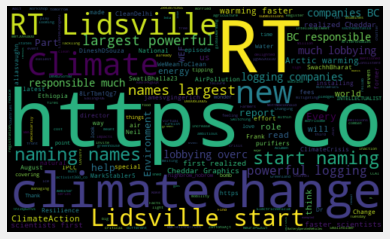

In [ ]:
allWords = ' '.join( [tweets for tweets in df['Tweets'] [df['Analysis'] == 'Positive']])
wordCloud = WordCloud(width=500, height=300, random_state=21, max_font_size=119).generate(allWords)

plt.imshow(wordCloud, interpolation='bilinear')
plt.axis('off')                                 # does not show grid and axes
plt.show()

**Negative wordcloud**

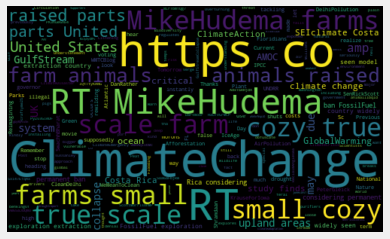

In [ ]:
# Visualizatn of Negative Word Cloud
allWords = ' '.join( [tweets for tweets in df['Tweets'] [df['Analysis'] == 'Negative']])
wordCloud = WordCloud(width=500, height=300, random_state=21, max_font_size=119).generate(allWords)

plt.imshow(wordCloud, interpolation='bilinear')
plt.axis('off')                                 # does not show grid and axes
plt.show()

## **Plotting comparative sentiment analysis**

**Initializing sentiment arrays for NLP and NB**

In [ ]:
nb = np.array([])                              # Array storing sentiments analysed using naive bayes
nlp = np.array([])                             # Array storing sentiments analysed using TextBlob

for tweet in df['Tweets']:
  p = predict_nb(tweet, log_prob, log_dict)    # calling prediction func
  # nb = np.append(nb,[p]) would store confidence value for each tweet
  if (p > 0):
    nb = np.append(nb,['Positive'])
  elif (p < 0):
    nb = np.append(nb,['Negative'])
  else:
    nb = np.append(nb,['Neutral'])
    
nlp = df['Analysis'].to_numpy()

print('nb array is: ', nb, '\n')
print('nlp array is: ', nlp, '\n')

nb array is:  ['Positive' 'Negative' 'Negative' 'Negative' 'Negative' 'Positive'
 'Positive' 'Negative' 'Positive' 'Positive' 'Positive' 'Positive'
 'Positive' 'Negative' 'Negative' 'Negative' 'Negative' 'Negative'
 'Negative' 'Negative' 'Negative' 'Negative' 'Negative' 'Negative'
 'Positive' 'Negative' 'Negative' 'Positive' 'Positive' 'Negative'
 'Negative' 'Positive' 'Negative' 'Negative' 'Positive' 'Negative'
 'Positive' 'Positive' 'Positive' 'Negative' 'Positive' 'Negative'
 'Positive' 'Negative' 'Negative' 'Negative' 'Negative' 'Negative'
 'Negative' 'Positive' 'Positive' 'Positive' 'Negative' 'Positive'
 'Positive' 'Negative' 'Negative' 'Positive' 'Positive' 'Negative'
 'Negative' 'Positive' 'Positive' 'Positive' 'Positive' 'Positive'
 'Positive' 'Positive' 'Negative' 'Positive' 'Positive' 'Positive'
 'Positive' 'Positive' 'Negative' 'Positive' 'Positive' 'Positive'
 'Positive' 'Negative' 'Positive' 'Positive' 'Positive' 'Negative'
 'Positive' 'Negative' 'Positive' 'Negative' 'Ne

**Plotting NP vs NLP**

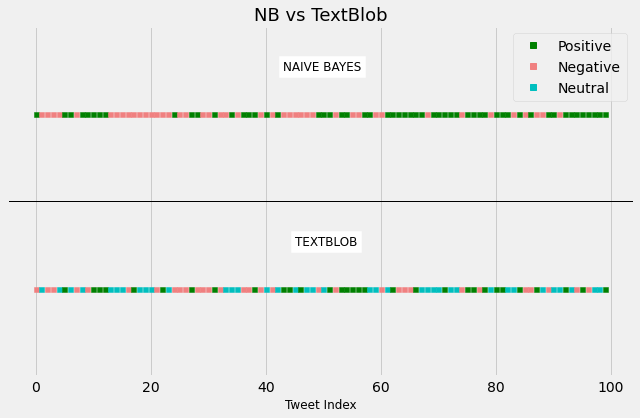

In [ ]:
from matplotlib.lines import Line2D

legend_elements = [Line2D([0], [0], marker='s', color='green', lw=0, label='Positive'),
                   Line2D([0], [0], marker='s', color='lightcoral', lw=0, label='Negative'),
                   Line2D([0], [0], marker='s', color='c', lw=0, label='Neutral')]

x_nb = 0
x_nlp = 0
y_nb = 7
y_nlp = 5
si = 25

fig,ax = plt.subplots(figsize=(10,6))
plt.axhline(6,color='black',linewidth=1)
for i in nb:
  if i == 'Positive':
    ax.scatter (x_nb,y_nb, color = 'green', s=si, marker='s')
  elif i == 'Negative':
    ax.scatter (x_nb,y_nb, color = 'lightcoral', s=si, marker='s')
  else:
    ax.scatter (x_nb,y_nb, color = 'c', s=si, marker='s')
  x_nb += 1

for i in nlp:
  if i == 'Positive':
    ax.scatter (x_nlp,y_nlp, color = 'green', s=si, marker='s')
  elif i == 'Negative':
    ax.scatter (x_nlp,y_nlp, color = 'lightcoral', s=si, marker='s')
  else:
    ax.scatter (x_nlp,y_nlp, color = 'c', s=si, marker='s')
  x_nlp += 1
  
plt.title("NB vs TextBlob", fontsize=18)
plt.xlabel('Tweet Index', fontsize=12)
ax.text(43,7.5,"NAIVE BAYES",fontsize=12, backgroundcolor='white')
ax.text(45,5.5,"TEXTBLOB",fontsize=12,backgroundcolor='white')

ax.legend(handles=legend_elements, loc='upper right')
ax.yaxis.set_visible(False)
plt.ylim([4,8])
plt.show()

**Plotting analysis comparision bw NB and TextBlob**

Text(0.5, 1.0, 'Comparison between algorithms')

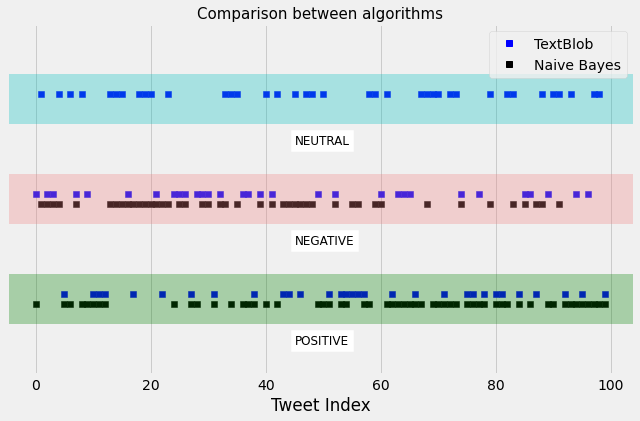

In [ ]:
fig,ax = plt.subplots(figsize=(10,6))
ax.axhspan(9, 10, facecolor='c', alpha=0.3)
ax.axhspan(7, 8, facecolor='lightcoral', alpha=0.3)
ax.axhspan(5, 6, facecolor='green', alpha=0.3)


legend_elements = [Line2D([0], [0], marker='s', color='b', lw=0, label='TextBlob'),
                   Line2D([0], [0], marker='s', color='black', lw=0, label='Naive Bayes')]

for i in range(len(nb)):
  if nb[i] == 'Positive':
    plt.scatter(i,5.4,color='black',marker='s')
  if nb[i] == 'Negative':
    plt.scatter(i,7.4,color='black',marker='s')
  # else:
  #   print(i)
  #   plt.scatter(i,9.4,color='black',marker='s')

for i in range(len(nlp)):
  if nlp[i] == 'Positive':
    plt.scatter(i,5.6,color='b',marker='s')
  if nlp[i] == 'Negative':
    plt.scatter(i,7.6,color='b',marker='s')
  elif nlp[i] == 'Neutral':
    plt.scatter(i,9.6,color='b',marker='s')

ax.legend(handles=legend_elements, loc='upper right')

ax.text(45,8.6,"NEUTRAL",fontsize=12, backgroundcolor='white')
ax.text(45,6.6,"NEGATIVE",fontsize=12, backgroundcolor='white')
ax.text(45,4.6,"POSITIVE",fontsize=12, backgroundcolor='white')
#ax.text(30,5.5,"NATURAL LANGUAGE PROCESSING",fontsize=12,backgroundcolor='white')
  
ax.yaxis.set_visible(False)
plt.ylim([4,11])
plt.xlabel('Tweet Index')
plt.title("Comparison between algorithms", fontsize=15)

**Plotting division of analysis in each algo**

Text(0.5, 1.0, 'Division of analysis')

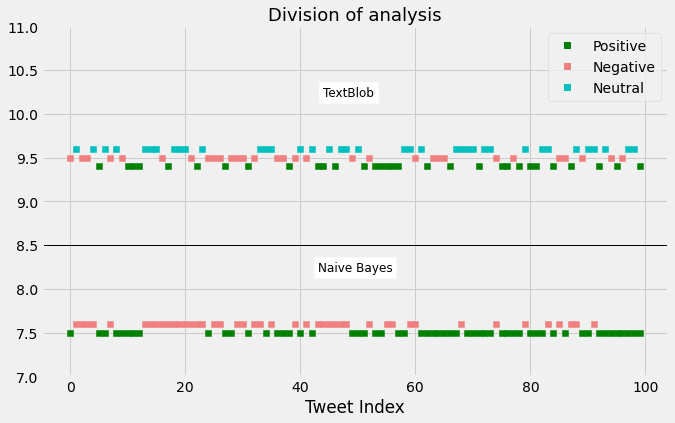

In [ ]:
fig,ax = plt.subplots(figsize=(10,6))

legend_elements = [Line2D([0], [0], marker='s', color='green', lw=0, label='Positive'),
                   Line2D([0], [0], marker='s', color='lightcoral', lw=0, label='Negative'),
                   Line2D([0], [0], marker='s', color='c', lw=0, label='Neutral')]

plt.axhline(8.5,color='black',linewidth=1)

for i in range(len(nlp)):
  if nlp[i] == 'Positive':
    plt.scatter(i,9.4,color='green',marker='s')
  if nlp[i] == 'Negative':
    plt.scatter(i,9.5,color='lightcoral',marker='s')
  elif nlp[i] == 'Neutral':
    plt.scatter(i,9.6,color='c',marker='s')

for i in range(len(nb)):
  if nb[i] == 'Positive':
    plt.scatter(i,7.5,color='green',marker='s')
  if nb[i] == 'Negative':
    plt.scatter(i,7.6,color='lightcoral',marker='s')

plt.ylim([7,11])
#ax.yaxis.set_visible(False)
ax.legend(handles=legend_elements, loc='upper right')

ax.text(44,10.2,"TextBlob",fontsize=12, backgroundcolor='white')
ax.text(43,8.2,"Naive Bayes",fontsize=12, backgroundcolor='white')
plt.xlabel('Tweet Index')
plt.title("Division of analysis", fontsize=18)